In [1]:
%autosave 300

Autosaving every 300 seconds


In [2]:
# from Cleanser import get_data, convert_time
from functools import reduce
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib

import seaborn as sns
from sklearn.cluster import DBSCAN, KMeans, MiniBatchKMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.datasets.samples_generator import make_blobs
from sklearn import metrics
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

from scipy.spatial.distance import cdist, pdist
from datetime import datetime
sns.set(color_codes=True)
# matplotlib.style.use("ggplot")
%matplotlib inline

In [3]:
# print(plt.style.available)
print(matplotlib.matplotlib_fname())

font_location = "C:Windows/Fonts/NanumBarunGothic.ttf"
# font_location = "/Users/RyuQae/Library/Fonts/NanumBarunGothic.otf"
# font_location = "/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf"
font_name = fm.FontProperties(fname=font_location).get_name()
matplotlib.rc('font', family=font_name)

print(matplotlib.rcParams["font.family"])

C:\Users\ryuqae\Anaconda3\lib\site-packages\matplotlib\mpl-data\matplotlibrc
['NanumBarunGothic']


In [4]:
tidy_df = pd.read_pickle('output/tidy_df.pkl')

In [5]:
tidy_df.shape

(2153476, 18)

In [6]:
ids = tidy_df.groupby('기간').ID.apply(set).reset_index().set_index('기간')
target_audience = list(ids.ID[0] & ids.ID[1] & ids.ID[2])

In [7]:
weekday = ['Mon','Tue','Wed','Thu','Fri']

In [8]:
prime = tidy_df[(tidy_df.시청시작시간.dt.hour >= 17)
#                 & (tidy_df.요일.isin(weekday))
                & (tidy_df.프로그램시청시간 >= 600)
#                 & (tidy_df.연령.astype(int)< 70)
               ].copy()

In [9]:
prime.가중치 = prime.가중치.astype(float)
prime.연령 = prime.연령.astype(int)

In [10]:
prime['장르'] = prime.방송사 + '_' + prime.대분류

In [12]:
prime.shape

(467739, 19)

In [13]:
agg_ = {
    '성별' : lambda x: x.replace({'1':'남', '2':'여'}).iloc[0],
    '연령' : lambda x: x.iloc[0],
    '시청시작시간' : min, 
    '시청종료시간' : max,
    '프로그램명' : lambda x: set(x),
    '방송사' : lambda x: set(x),
    '프로그램시청시간' : sum,
    '장르' : lambda x: tuple(x),
    '가중치' : lambda x: np.mean(x)
       }

In [14]:
temp = prime.groupby(['기간', '일자', '요일', 'ID']).agg(agg_)

In [15]:
temp['진입시간대'] = temp.시청시작시간.dt.hour
temp['이탈시간대'] = temp.시청종료시간.dt.hour
temp['시청프로그램수'] = temp.프로그램명.apply(len)
temp['시청채널수'] = temp.방송사.apply(len)
temp['연령대'] = pd.cut(x=temp.연령.astype(int), bins=[0, 19, 49, 70], labels=['10대 이하','20-49','50대 이상'])

In [16]:
temp.이탈시간대.replace({0:24, 1:25, 2:26, 3:27}, inplace=True)
temp.진입시간대.replace({0:24, 1:25, 2:26, 3:27}, inplace=True)

In [17]:
temp[['프로그램시청시간', 
      '진입시간대', 
      '이탈시간대', 
      '시청프로그램수', 
      '시청채널수']].reset_index().sort_values(by='ID').head(10)

,기간,일자,요일,ID,프로그램시청시간,진입시간대,이탈시간대,시청프로그램수,시청채널수
0,T2,20160822,Mon,1401861aa,19814,18,24,6,3
6284,T2,20160825,Thu,1401861aa,19313,17,24,7,4
8355,T2,20160826,Fri,1401861aa,5454,23,24,2,2
10402,T2,20160827,Sat,1401861aa,13959,19,24,5,2
12539,T2,20160828,Sun,1401861aa,15544,19,23,6,4
14781,T2,20160829,Mon,1401861aa,8665,18,23,6,5
16914,T2,20160830,Tue,1401861aa,3829,23,24,2,2
2176,T2,20160823,Tue,1401861aa,2025,20,21,1,1
4265,T2,20160824,Wed,1401861aa,1500,21,22,2,2
1,T2,20160822,Mon,1401861ab,19814,18,24,6,3


In [18]:
temp[['프로그램시청시간', 
      '진입시간대', 
      '이탈시간대',
      '시청프로그램수', 
      '시청채널수']].corr()

,프로그램시청시간,진입시간대,이탈시간대,시청프로그램수,시청채널수
프로그램시청시간,1.000000,-0.558152,0.513077,0.856085,0.671533
진입시간대,-0.558152,1.000000,0.273608,-0.579735,-0.494410
이탈시간대,0.513077,0.273608,1.000000,0.399052,0.329410
시청프로그램수,0.856085,-0.579735,0.399052,1.000000,0.832225
시청채널수,0.671533,-0.494410,0.329410,0.832225,1.000000


In [48]:
vec_extend = temp[['프로그램시청시간', 
      '진입시간대', 
      '이탈시간대',
      '시청프로그램수', 
      '시청채널수']]

vec = temp[['이탈시간대', '진입시간대', '시청채널수']]

In [49]:
def scaler(df, stype='s'):
    if stype == 's':
        return StandardScaler().fit_transform(df)
    else:
        return MinMaxScaler().fit_transform(df)

In [50]:
def do_kmeans(df, stype='s', k_range=range(2,15)):
    df = scaler(df, stype)
    KMs = []
    Ls = []

    start = datetime.now()
    for n_clusters in k_range:
        print("# of Ks: ", n_clusters, "centroids")
        kmeans = KMeans(n_clusters=n_clusters).fit(df)
        labels = kmeans.labels_
        KMs.append(kmeans)
        Ls.append(labels)
    print("Finished Learning: ",datetime.now() - start)
    
    centroids = [k.cluster_centers_ for k in KMs]
    D_k = [cdist(df, cent, 'euclidean') for cent in centroids]
    cIdx = [np.argmin(D,axis=1) for D in D_k]
    dist = [np.min(D,axis=1) for D in D_k]
    avgWithinSS = [sum(d)/df.shape[0] for d in dist]
    
    return KMs, Ls, centroids, avgWithinSS, cIdx

In [51]:
# elbow curve
def elbow(awss, kIdx, k_range=range(2,15)):
    fig = plt.figure(figsize=(8,5))
    ax = fig.add_subplot(111)
    ax.plot(k_range, awss, '*-')
    ax.plot(k_range[kIdx], awss[kIdx], marker='o', markersize=12, 
    markeredgewidth=2, markeredgecolor='hotpink', markerfacecolor='None')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Average within-cluster sum of squares')
    plt.title('Elbow for K-means clustering')

In [52]:
kms, labs, cents, awss, cidx = do_kmeans(vec)

# of Ks:  2 centroids
# of Ks:  3 centroids
# of Ks:  4 centroids
# of Ks:  5 centroids
# of Ks:  6 centroids
# of Ks:  7 centroids
# of Ks:  8 centroids
# of Ks:  9 centroids
# of Ks:  10 centroids
# of Ks:  11 centroids
# of Ks:  12 centroids
# of Ks:  13 centroids
# of Ks:  14 centroids
Finished Learning:  0:00:17.601394


In [98]:
num_groups = 7
idx = num_groups - 2

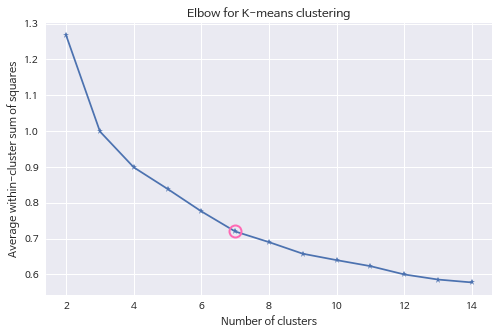

In [99]:
elbow(awss, kIdx=idx)

## PCA for Visualization


In [100]:
pca = PCA(n_components=2)
projection = pd.DataFrame(pca.fit_transform(vec_extend))
projection.columns = ['first', 'second']
projection['group'] = labs[idx]
projection.sort_values(by='group').sample(5)

,first,second,group
58164,-332.329783,1.810776,5
63073,-4712.330112,-3.168989,6
77065,-273.328757,-1.076150,4
80533,-1945.328404,-0.006014,4
50409,-6152.330687,-4.206324,6


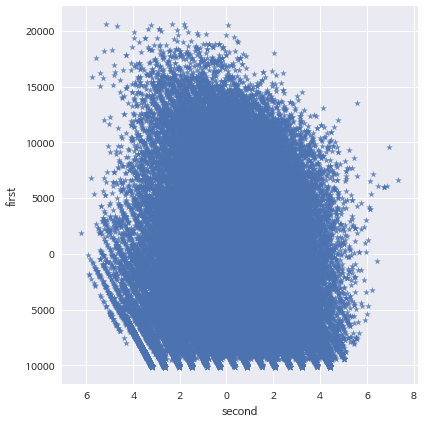

In [101]:
sns.lmplot("second", "first", data=projection, fit_reg=False, size=6, markers='*')

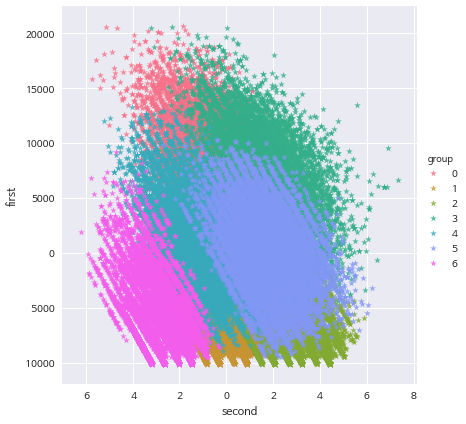

In [102]:
sns.lmplot("second", "first", data=projection, 
           fit_reg=False, size=6, hue="group", legend=True, markers='*')

In [103]:
# for idx in range(max(labs[4]) + 1):
clustered = pd.concat(list(map(lambda x: pd.DataFrame(temp[labs[idx] == x].describe().loc['mean']),
                   range(max(labs[idx])+1))), axis=1,)
clustered.columns = range(num_groups)

In [104]:
np.bincount(labs[idx])

array([16184, 10118,  8541, 10813, 15487, 14454, 14035], dtype=int64)

In [105]:
clustered.applymap(lambda x: '%.2f' % x)

,0,1,2,3,4,5,6
가중치,4820.14,5109.89,5275.10,4397.46,4896.84,4603.88,5427.80
연령,51.78,47.03,42.25,52.50,48.17,52.34,43.52
프로그램시청시간,16904.93,5630.95,3960.72,17600.67,11640.10,10620.71,5107.07
진입시간대,17.44,19.89,17.75,17.52,19.80,17.74,22.03
이탈시간대,23.60,21.64,18.90,23.45,23.65,21.30,23.56
시청프로그램수,6.85,2.46,2.00,8.93,5.10,5.19,2.00
시청채널수,3.87,1.67,1.58,6.77,3.67,3.63,1.57


In [122]:
from IPython.display import display

def group_summary(t):
    print("\n==================== 그룹 %s 요약 ==================== " % t)
    size = np.bincount(labs[idx])[t]
    age = pd.DataFrame(temp[labs[idx]==t].groupby('연령대').가중치.apply(sum))
    age['비율'] = age.가중치/age.가중치.sum()
    display(age)
    display(pd.DataFrame(temp[labs[idx]==t].reset_index().요일.value_counts()))
    lines = zip(temp[labs[idx]==t].프로그램명.apply(lambda x: list(set(x))), temp[labs[idx]==t].가중치)

    weighted_sess = map(lambda line: list(map(lambda x : (x, line[1]), line[0])), lines)
    flatten = [item for sublist in weighted_sess for item in sublist]
    counts = {}
    for k, v in flatten:
        if k in counts.keys():
            counts[k] += v
        else:
            counts[k] = v
        
    plot_df = pd.DataFrame.from_dict(counts, orient='index').\
        sort_values(by=0, ascending=False)
    plot_df[:20].plot(kind='barh', figsize=(8,6), legend=False, fontsize=11).invert_yaxis()
#     plt.ylim(0,)
    plt.title("그룹 %s 시청자 수 기준 상위 프로그램" % t)




==================== 그룹 0 요약 ==================== 


,가중치,비율
연령대,,
10대 이하,7679929.0,0.098449
20-49,30078307.5,0.385574
50대 이상,40250875.2,0.515977


,요일
Sun,3125
Sat,3006
Mon,2162
Tue,2078
Fri,2058
Thu,1950
Wed,1805



==================== 그룹 1 요약 ==================== 


,가중치,비율
연령대,,
10대 이하,9299735.5,0.179872
20-49,22373183.4,0.432734
50대 이상,20028956.3,0.387393


,요일
Mon,1572
Sun,1504
Wed,1493
Thu,1473
Tue,1384
Sat,1376
Fri,1316



==================== 그룹 2 요약 ==================== 


,가중치,비율
연령대,,
10대 이하,11491043.5,0.255047
20-49,19162582.5,0.425319
50대 이상,14400986.9,0.319634


,요일
Sat,1414
Sun,1401
Tue,1192
Wed,1152
Thu,1149
Fri,1132
Mon,1101



==================== 그룹 3 요약 ==================== 


,가중치,비율
연령대,,
10대 이하,3790679.1,0.079720
20-49,17331375.3,0.364489
50대 이상,26427705.4,0.555791


,요일
Sat,1727
Sun,1642
Wed,1541
Fri,1525
Tue,1500
Mon,1442
Thu,1436



==================== 그룹 4 요약 ==================== 


,가중치,비율
연령대,,
10대 이하,7676989.9,0.101230
20-49,36755594.4,0.484663
50대 이상,31404764.7,0.414107


,요일
Fri,2402
Tue,2341
Mon,2311
Thu,2258
Wed,2234
Sat,2085
Sun,1856



==================== 그룹 5 요약 ==================== 


,가중치,비율
연령대,,
10대 이하,8778198.2,0.131915
20-49,20957131.9,0.314934
50대 이상,36809185.6,0.553151


,요일
Sun,2744
Wed,2011
Thu,2008
Sat,1979
Tue,1970
Fri,1947
Mon,1795



==================== 그룹 6 요약 ==================== 


,가중치,비율
연령대,,
10대 이하,11108861.0,0.145826
20-49,44352984.3,0.582220
50대 이상,20717274.7,0.271955


,요일
Mon,2334
Wed,2206
Thu,2191
Fri,2159
Tue,2131
Sat,1630
Sun,1384


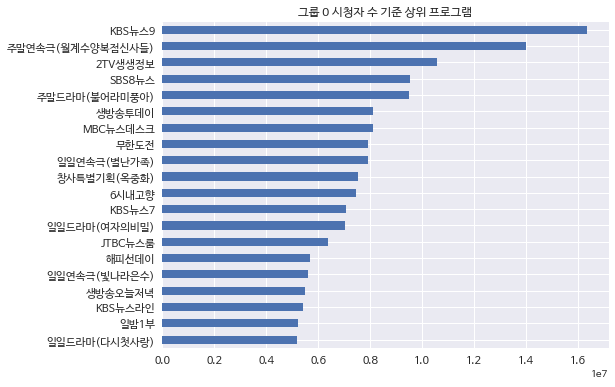

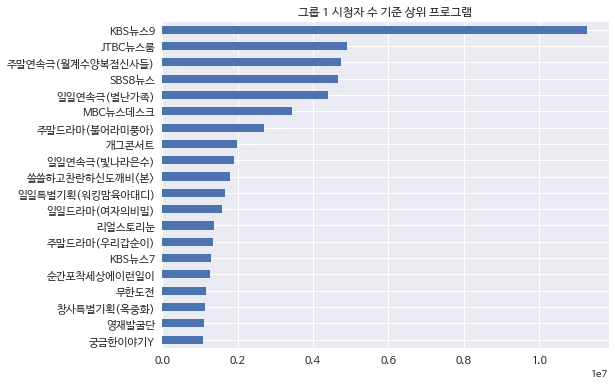

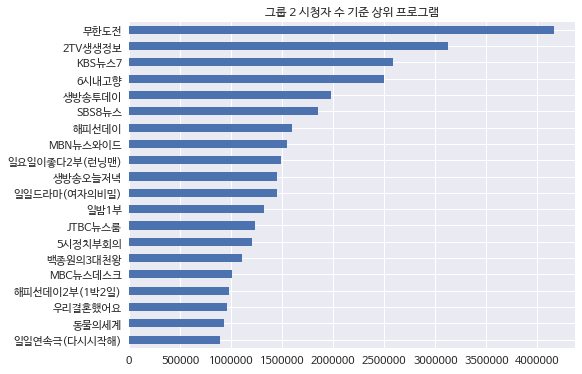

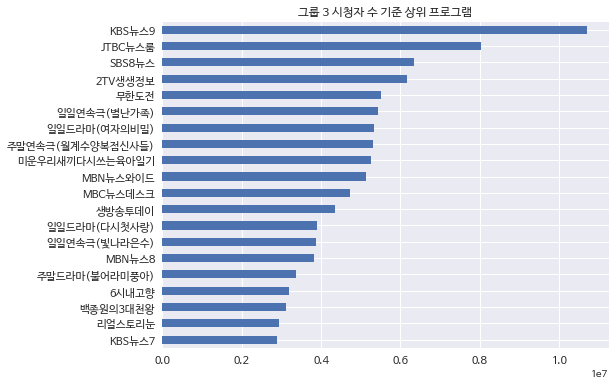

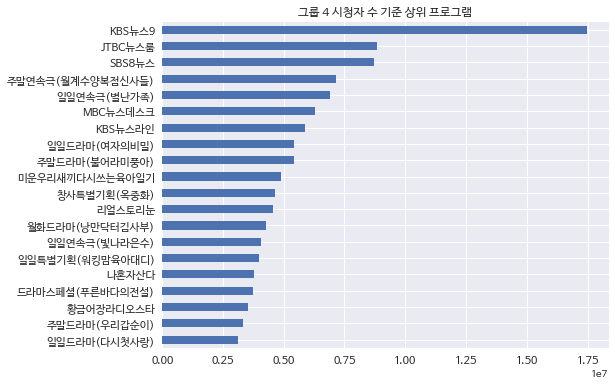

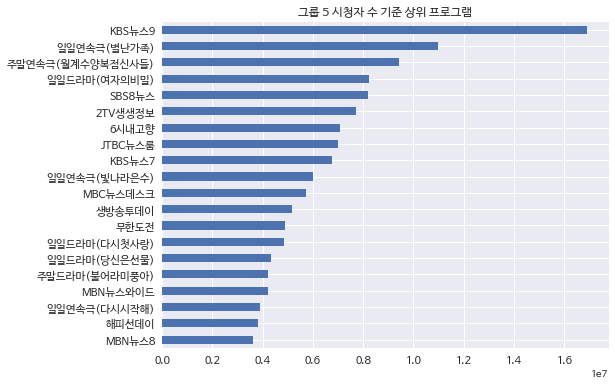

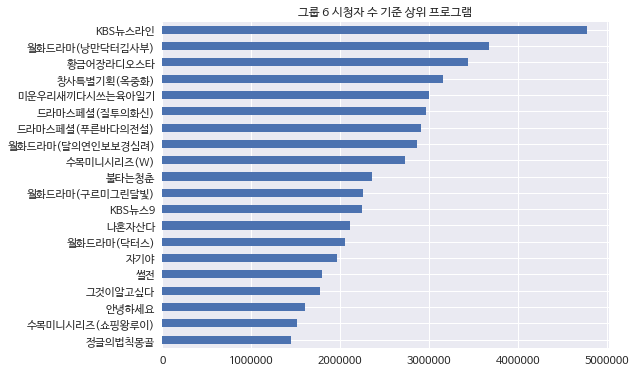

In [123]:
for i in range(num_groups):
    group_summary(i)

### 그룹의 시청자들이 시청하는 처음/마지막 프로그램의 장르

In [120]:
t=0
size = np.bincount(labs[idx])[t]

(0, 17)

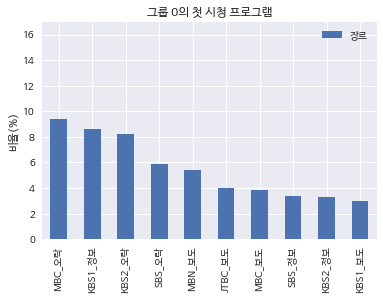

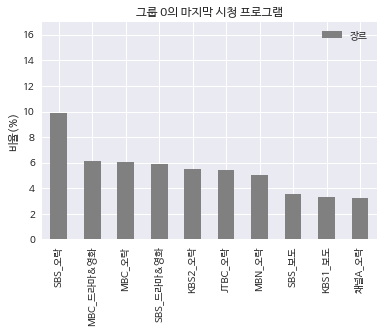

In [121]:
pd.DataFrame(temp[labs[idx]==t].장르.apply(lambda x: x[0]).\
             value_counts()[:10]/size*100).plot(kind='bar')
plt.title("그룹 %s의 첫 시청 프로그램" % t)
plt.ylabel('비율(%)')
plt.ylim(0,17)

pd.DataFrame(temp[labs[idx]==t].장르.apply(lambda x: x[-1]).\
             value_counts()[:10]/size*100).plot(kind='bar', color='grey')
plt.title("그룹 %s의 마지막 시청 프로그램" % t)
plt.ylabel('비율(%)')
plt.ylim(0,17)

# TVPro2Vec

In [ ]:
from gensim.models import word2vec
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO )

In [ ]:
tidy = tidy_df[tidy_df.프로그램시청시간  >= 600].copy()

In [ ]:
programs = tidy.groupby(['ID','일자']).프로그램명.apply(lambda x: ' '.join(x).split()).reset_index().프로그램명.tolist()

In [ ]:
len(programs)

In [ ]:
# model = gensim.models.Word2Vec(programs, min_count=1)
model = word2vec.Word2Vec(programs, size=300, window=10, min_count=5, workers=8)

In [ ]:
model.most_similar(positive=['JTBC뉴스룸'], topn=20)